# Summary
- Group 4 (Akul Bajaj, Nhi Nguyen, Yusong Wang, Ruirui Zhang)

- Data : GDELT 1.0 Event Database (GDELT.MASTERREDUCEDV2.1979-2013.zip) (http://data.gdeltproject.org/events/index.html)

- Cluster Setting : Multi Node, No Isolation Shared, Runtime : 11.0, Worker/Driver type : e2-highmem-2 (Min workers : 1, Max workers : 6 with autoscaling)

- We took a couple of steps to try to make our code run more efficiently. Primarily we dictated the executor and driver memory to be two gigabytes. In addition, used the cache() function on the RDD. Finally we in some areas of our notebook we chose to use reduceByKey() opposed to the groupByKey() when feasible.

- Objectives : Make observations using the event database to see where and when events are more likely. We accomplished this by creating a graphing which locations have the most events, when the most events take place, and what sort of events are common in certain places.

In [0]:
sc

SparkContext 

 Spark UI 

 
 Version 
 v3.3.0 
 Master 
 spark://driver-proxy:7077 
 AppName 
 Databricks Shell

In [0]:
from datetime import datetime

from geopy.geocoders import Nominatim
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import pyspark

# Check default configurations

In [0]:
sc._conf.getAll()

Out[3]: [('spark.databricks.preemption.enabled', 'true'),
 ('spark.sql.hive.metastore.jars', '/databricks/databricks-hive/*'),
 ('spark.driver.tempDirectory', '/local_disk0/tmp'),
 ('spark.databricks.clusterUsageTags.onInstancePool', 'false'),
 ('spark.sql.warehouse.dir', 'dbfs:/user/hive/warehouse'),
 ('spark.databricks.managedCatalog.clientClassName',
  'com.databricks.managedcatalog.ManagedCatalogClientImpl'),
 ('spark.hadoop.fs.gs.impl',
  'shaded.databricks.com.google.cloud.hadoop.fs.gcs.GoogleHadoopFileSystem'),
 ('spark.hadoop.fs.fcfs-s3.impl.disable.cache', 'true'),
 ('spark.hadoop.fs.s3a.retry.limit', '20'),
 ('spark.sql.streaming.checkpointFileManagerClass',
  'com.databricks.spark.sql.streaming.DatabricksCheckpointFileManager'),
 ('spark.databricks.service.dbutils.repl.backend',
  'com.databricks.dbconnect.ReplDBUtils'),
 ('spark.hadoop.databricks.s3.verifyBucketExists.enabled', 'false'),
 ('spark.streaming.driver.writeAheadLog.allowBatching', 'true'),
 ('spark.databricks.cl

In [0]:
# set 'spark.executor.memory' to '2g'
sc._conf.set('spark.executor.memory', '2g')
sc._conf.get('spark.executor.memory')

Out[4]: '2g'

# Data Cleaning

In [0]:
# import file from GCP bucket
inputs_rdd = sc.textFile("gs://msds694_group_project/GDELT.MASTERREDUCEDV2.TXT")

In [0]:
# take a look at the format of our data
inputs_rdd.take(3)

Out[6]: ['Date\tSource\tTarget\tCAMEOCode\tNumEvents\tNumArts\tQuadClass\tGoldstein\tSourceGeoType\tSourceGeoLat\tSourceGeoLong\tTargetGeoType\tTargetGeoLat\tTargetGeoLong\tActionGeoType\tActionGeoLat\tActionGeoLong',
 '19790101\tAFR\tFRA\t043\t1\t4\t1\t2.8\t\t\t',
 '19790101\tAFR\tFRA\t050\t2\t9\t1\t3.5\t\t\t\t\t\t\t\t\t']

In [0]:
# We don't want the first line (header) so we're removing it
header = inputs_rdd.first()
no_header_inputs = inputs_rdd.filter(lambda x: x not in header)

In [0]:
no_header_inputs.take(3)

Out[8]: ['19790101\tAFR\tFRA\t043\t1\t4\t1\t2.8\t\t\t',
 '19790101\tAFR\tFRA\t050\t2\t9\t1\t3.5\t\t\t\t\t\t\t\t\t',
 '19790101\tAFR\tFRAGOV\t043\t2\t19\t1\t2.8\t1\t46\t2\t1\t46\t2\t1\t46\t2']

In [0]:
# define some functions for data cleaning
    
def retrieve_column(array, col):
    try:
        return array[col]
    except:
        pass
    
def convert_string_to_timestamp(string):
    try:
        return datetime.strptime(string, '%Y%M%d').date()
    except:
        pass

def string_to_int(x):
    try:
        return int(x)
    except:
        return 0

def string_to_float(x):
    try:
        return float(x)
    except:
        return 0

In [0]:
# parse text and get each line into an rdd
parsed_input = no_header_inputs.map(lambda x : x.split("\t"))\
                    .map(lambda x : [convert_string_to_timestamp(retrieve_column(x, 0)),
                                     retrieve_column(x, 1), 
                                     retrieve_column(x, 2),
                                     string_to_int(retrieve_column(x,3)),
                                     string_to_int(retrieve_column(x,4)),
                                     string_to_int(retrieve_column(x,5)),
                                     string_to_int(retrieve_column(x,6)),
                                     string_to_float(retrieve_column(x,7)),
                                     string_to_float(retrieve_column(x,8)),
                                     string_to_float(retrieve_column(x,9)),
                                     string_to_float(retrieve_column(x,10)),
                                     string_to_float(retrieve_column(x,11)),
                                     string_to_float(retrieve_column(x,12)),
                                     string_to_float(retrieve_column(x,13)),
                                     string_to_float(retrieve_column(x,14)),
                                     string_to_float(retrieve_column(x,15)),
                                     string_to_float(retrieve_column(x,16))])\
                    .cache()

In [0]:
# take a look at the first 5 records
parsed_input.take(5)

Out[11]: [[datetime.date(1979, 1, 1),
  'AFR',
  'FRA',
  43,
  1,
  4,
  1,
  2.8,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 [datetime.date(1979, 1, 1),
  'AFR',
  'FRA',
  50,
  2,
  9,
  1,
  3.5,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 [datetime.date(1979, 1, 1),
  'AFR',
  'FRAGOV',
  43,
  2,
  19,
  1,
  2.8,
  1.0,
  46.0,
  2.0,
  1.0,
  46.0,
  2.0,
  1.0,
  46.0,
  2.0],
 [datetime.date(1979, 1, 1),
  'AFR',
  'ZMB',
  100,
  2,
  18,
  3,
  -5.0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 [datetime.date(1979, 1, 1),
  'ARG',
  'ARGGOVMIL',
  172,
  1,
  4,
  4,
  -5.0,
  4.0,
  -14.4432,
  28.4517,
  4.0,
  -14.4432,
  28.4517,
  4.0,
  -14.4432,
  28.4517]]

# EDA and Visualizations

## Display Top 20 Locations with the most events from 1979 to 2013 (Nhi Nguyen)

Create a bar chart showing top 20 locations with the most events in descending order.

USA had the most GDELT events from 1979 to 2013: about 13.9 million events.

In [0]:
# get a list of unique locations
unique_locations = parsed_input.map(lambda x: x[2]).distinct().sortBy(lambda x: x)
unique_locations.collect()

Out[12]: [' ',
 ' ABR010',
 ' ABR012',
 ' ABR012GOV',
 ' ABR012HLH',
 ' ABRRAC010',
 ' ABRRAC010EDU',
 ' ABRRAC013',
 ' ABW',
 ' ABWBUS',
 ' ABWGOV',
 ' ADR010',
 ' ADR010CVL',
 ' ADR030',
 ' ADR060',
 ' ADRSYN010',
 ' ADRSYN030',
 ' ADRSYN060',
 ' ADRSYN062',
 ' AFG',
 ' AFGAGR',
 ' AFGBUS',
 ' AFGCHR',
 ' AFGCOP',
 ' AFGCRM',
 ' AFGCVL',
 ' AFGEDU',
 ' AFGELI',
 ' AFGELIGOV',
 ' AFGELILEG',
 ' AFGELIMIL',
 ' AFGELIUAF',
 ' AFGENV',
 ' AFGGOV',
 ' AFGGOVAGR',
 ' AFGGOVBUS',
 ' AFGGOVBUSCOP',
 ' AFGGOVCOP',
 ' AFGGOVEDU',
 ' AFGGOVENV',
 ' AFGGOVHLH',
 ' AFGGOVHRI',
 ' AFGGOVJUD',
 ' AFGGOVLAB',
 ' AFGGOVMED',
 ' AFGGOVMIL',
 ' AFGGOVREF',
 ' AFGGOVSPY',
 ' AFGHLH',
 ' AFGHRI',
 ' AFGINSTAL',
 ' AFGINSTALBUS',
 ' AFGINSTALCHR',
 ' AFGINSTALCOP',
 ' AFGINSTALCRM',
 ' AFGINSTALCVL',
 ' AFGINSTALEDU',
 ' AFGINSTALELI',
 ' AFGINSTALGOV',
 ' AFGINSTALJUD',
 ' AFGINSTALLEG',
 ' AFGINSTALMED',
 ' AFGINSTALMIL',
 ' AFGINSTALMOS',
 ' AFGINSTALMOSUAF',
 ' AFGINSTALOPP',
 ' AFGINSTALPTY',
 ' AFGI

In [0]:
# get top 20 locations with the most events
# There is a blank value in the locations list so we will exclude those records from our counts
event_count = parsed_input.filter(lambda x: x[2] != ' ')\
                          .map(lambda x: [x[2], x[4]])\
                          .filter(lambda x: x != ' ')\
                          .reduceByKey(lambda x, y : x+y)\
                          .sortBy(lambda x: x[1], ascending=False)\
                          .take(20)

In [0]:
event_count

Out[14]: [('USA', 13898822),
 ('GOV', 10490691),
 ('BUS', 3714376),
 ('COP', 3384572),
 ('CVL', 3255617),
 ('MED', 3152890),
 ('RUS', 2941101),
 ('MIL', 2795094),
 ('ISR', 2708577),
 ('CHN', 2668181),
 ('GBR', 2637887),
 ('EDU', 2428042),
 ('LEG', 2371558),
 ('USAGOV', 2219864),
 ('IRN', 2139235),
 ('IRQ', 1963875),
 ('JUD', 1741158),
 ('PAK', 1652424),
 ('FRA', 1603341),
 ('AFG', 1515639)]

In [0]:
# create a dataframe with locations codes and number of events
event_count_df = pd.DataFrame(event_count, columns=['Locations', 'Number of Events'])

# create a bar plot
fig = px.bar(event_count_df, x='Locations', y="Number of Events", title="Top 20 Locations with the Most Events")
fig.show()

## Display Trend of Number of Events from 1979 to 2013 (Ruirui Zhang)

Create a line plot for the trend of number of event from 1979 to 2013

In [0]:
# remove the year 2014 because data missing
yearly_event_count = parsed_input.filter(lambda x: x[2] != ' ')\
                          .map(lambda x: [x[0].year, x[4]])\
                          .filter(lambda x: x != ' ' and x[0] != 2014)\
                          .reduceByKey(lambda x, y : x+y)\
                          .sortBy(lambda x: x[0], ascending=True)\
                          .take(20)

In [0]:
# create a dataframe with locations codes and number of events
yearly_event_count_df = pd.DataFrame(yearly_event_count, columns=['Year', 'Number of Events'])

# create a bar plot
fig = px.line(yearly_event_count_df, x='Year', y="Number of Events", title="Trend of Number of Events from 1979 to 2013",markers = True)
fig.show()

## Display the count for each event type characterized by CAMEO code (Yusong Wang)

Create a bar chart displaying how many event are there for each event type.
Referring to http://data.gdeltproject.org/documentation/CAMEO.Manual.1.1b3.pdf
Chapter 6 Page 131 to 138

In [0]:
CAMEO = no_header_inputs.map(lambda x: x.split('\t'))#map(lambda x : x.split("\t"))

In [0]:
sa = CAMEO.map(lambda x: (x[3][:2], 1)).reduceByKey(lambda x, y : x+y).sortBy(lambda x: x[0], ascending=True).collect()

In [0]:
sa_df = pd.DataFrame(sa, columns=['CAMEO', 'Counts'])
sa_df['Event Type'] = ['missing', 'Make Public Statement', 'Appeal', 'Express Intent to Cooperate', 'Consult', 'Engage in Diplomatic Coperation','Engage in Material Cooperation', 'Provid aid', 'Yield', 'Investigate', 'Demand', 'Disapprove', 'Reject', 'Threaten', 'Protest', 'Exhibit Force Posture', 'Reduce Relations', 'Coerce', 'Assult', 'Fight', 'Use Unconventional Mass Violence']
# create a bar plot
fig = px.bar(sa_df, x='Event Type', y="Counts", title="Event Count by Event Type", orientation = 'v')
fig.show()

## Display a scatterplot of lattitudes and longitudes. (Akul Bajaj)

Create a map/scatterplot to demonstrate which regions are the source of more empathetic comments. This is characterized my a CAMEO code of '018'.

In [0]:
emp = parsed_input.map(lambda x: (x[3], x[9], x[10])).filter(lambda x: x[0] == 18)
emp.take(20)

emp2 = emp.collect()


In [0]:
df1 = pd.DataFrame(emp2, columns=['cameo_code', 'source_latitude', 'source_longitude'])

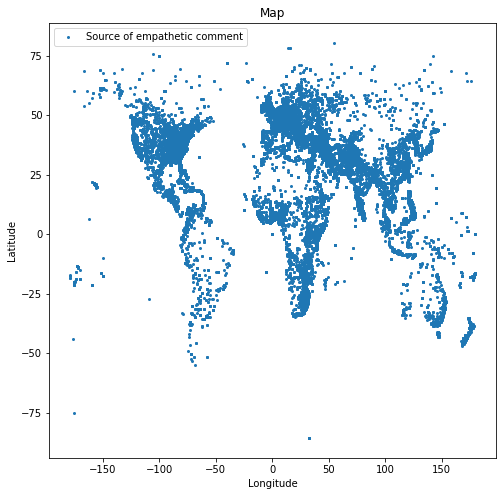

In [0]:
import matplotlib.pyplot as plt

# Set the size of the figure
plt.figure(figsize=(8, 8))

# Plot the longitudes and latitudes
plt.scatter(df1['source_longitude'], df1['source_latitude'], s=4)

# Set the axis labels
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(['Source of empathetic comment'])
plt.title('Map')

plt.show()

We can see the United States and most of Europe are the source of many empathetic comments. On the other hand, Northern Africa, Russia, and Southern America tend not to make empathetic comments.